# Filter comparison on LOD variation

## First, required libraries are loaded

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import re,math
import numpy as np
from scipy import signal,interpolate
#plt.style.use('dark_background') #uncomment for sensitive eyes
plt.style.use('classic')
plt.rcParams['figure.figsize'] = (12, 7)

## Data is read and loaded from file

In [3]:
datf = pd.read_csv("Data.csv") #Quick csv of lod is used for exemple
datf.head(5) #will show the first five lnes of the data file

,LOD
0,2.5319
1,2.5864
2,2.6674
3,2.7494
4,2.8136


## Signal plot

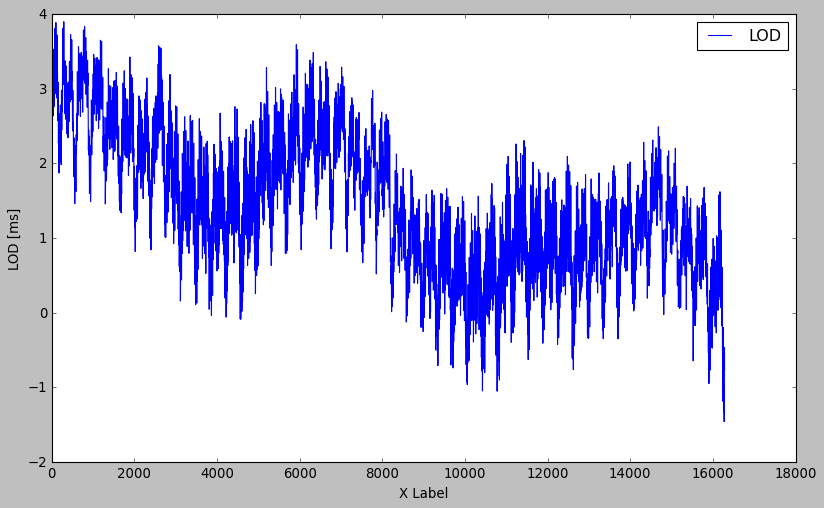

In [3]:
x = np.arange(len(datf))
sig = datf.LOD
plt.figure()
plt.plot(x,sig, c = 'b', label = 'LOD')
plt.xlabel('X Label')
plt.ylabel('LOD [ms]');
plt.legend(loc="upper right");

## Frequency response of Kaiser and Butterworth filter (low pass) 

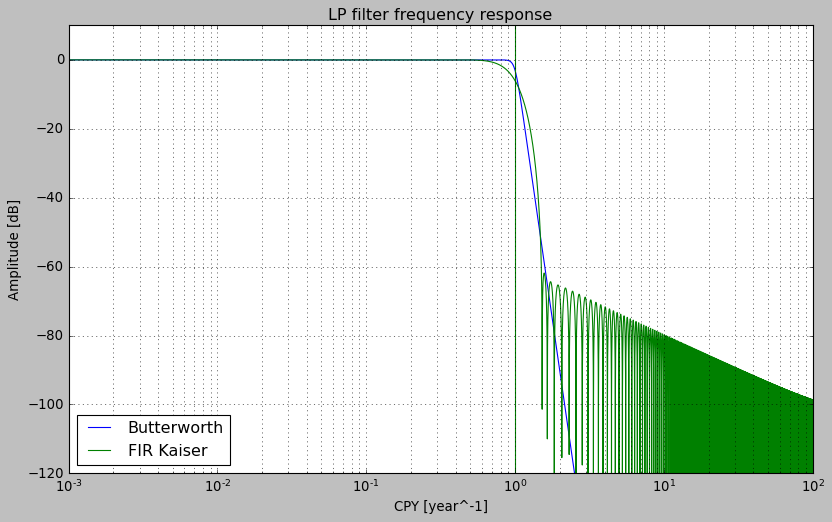

In [4]:
#Butterworth low pass
fs = 365 #sampling frequency of 365 sample per year (thus now talking in cpy)
cutoff_cpy = 1
order = 15 #order of the butterworth filter
sos = signal.butter(order, cutoff_cpy, 'low', fs = fs, output = 'sos') #generate filter
w, h = signal.sosfreqz(sos, worN = 2**18) #generate frequency response

#FIR kaiser low pass
nyq_rate = fs / 2.0 # The Nyquist rate of the signal.
width = 1/nyq_rate # The desired width of the transition from pass to stop, relative to the Nyquist rate.
ripple_db = 60.0 # The desired attenuation in the stop band, in dB.
# Compute the order and Kaiser parameter for the FIR filter.
N, beta = signal.kaiserord(ripple_db, width)
# Use firwin with a Kaiser window to create a lowpass FIR filter.
taps = signal.firwin(N, cutoff_cpy/nyq_rate, window=('kaiser', beta))
wfir, hfir = signal.freqz(taps, worN= 2**18) #generate frequency response

#Plot
plt.figure()
plt.semilogx((w/np.pi)*nyq_rate, 20*np.log10(abs(h)), label = 'Butterworth')
plt.semilogx((wfir/np.pi)*nyq_rate, 20*np.log10(abs(hfir)), label = 'FIR Kaiser')
plt.title('LP filter frequency response')
plt.xlabel('CPY [year^-1]')
plt.ylabel('Amplitude [dB]')
plt.xlim([1e-3, 100])
plt.ylim([-120, 10])
plt.grid(which='both', axis='both', linestyle='dotted')

plt.axvline(cutoff_cpy, color='green') # cutoff frequency in green
plt.legend(loc="lower left");
plt.show()

## Apply filter to the data

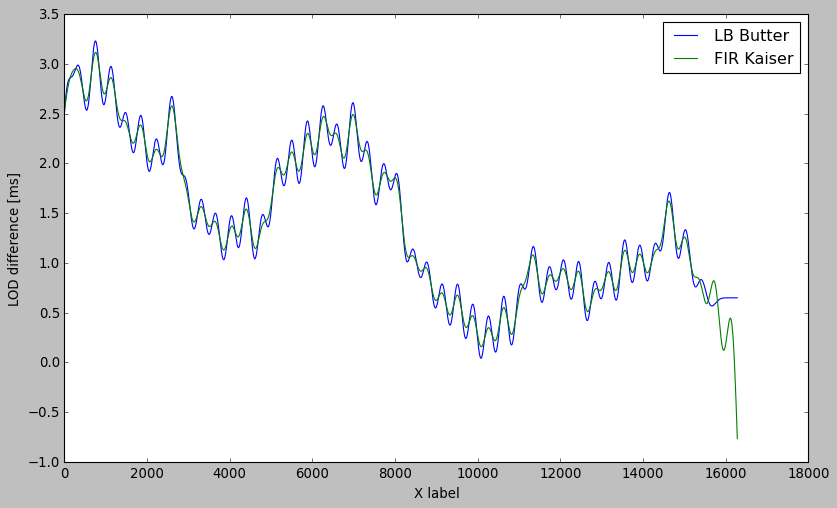

In [5]:
filtered_butter  = signal.sosfiltfilt(sos, sig) #filtfilt is used to avoid phase shift (double pass of the filter, straight and reverse)
filtered_FIR = signal.filtfilt(taps, 1.0, sig)
#plot
plt.figure()
plt.plot(x,filtered_butter, label = 'LB Butter')
plt.plot(x,filtered_FIR, label = 'FIR Kaiser')
plt.ylabel('LOD difference [ms]')
plt.xlabel('X label')
plt.legend(loc="upper right");

## Frequency response of Kaiser and Butterworth filter (band pass) 

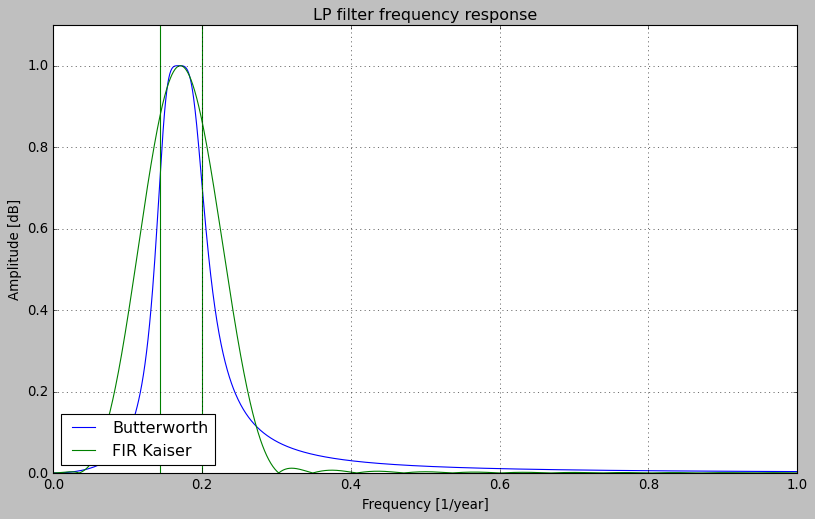

In [6]:
#Butterworth band pass
cutoff_cpy = np.array([1/7, 1/5]) #both cut off frequencies are given
order = 2
sos = signal.butter(order, cutoff_cpy, 'bandpass', fs = fs, output = 'sos') #filter is designed
w, h = signal.sosfreqz(sos, worN = 2**18) #frequency response if computed

#FIR kaiser low pass
width = 0.2/nyq_rate # The desired width of the transition from pass to stop,
ripple_db = 50.0 # The desired attenuation in the stop band, in dB.
# Compute the order and Kaiser parameter for the FIR filter.
N, beta = signal.kaiserord(ripple_db, width)
# Use firwin with a Kaiser window to create a band pass FIR filter.
taps = signal.firwin(N, cutoff_cpy/nyq_rate, window=('kaiser', beta), pass_zero = False)
wfir, hfir = signal.freqz(taps, worN= 2**18)

#Plot
plt.figure()
plt.plot((w/np.pi)*nyq_rate, abs(h), label = 'Butterworth')
plt.plot((wfir/np.pi)*nyq_rate, abs(hfir), label = 'FIR Kaiser')
plt.title('LP filter frequency response')
plt.xlabel('Frequency [1/year]')
plt.ylabel('Amplitude [dB]')
plt.xlim([0, 1])
plt.ylim([0, 1.1])
plt.grid(which='both', axis='both', linestyle='dotted')
for cf in cutoff_cpy:
    plt.axvline(cf, color='green') # cutoff frequencies in green
plt.legend(loc="lower left");
plt.show()

## Apply filter to the data

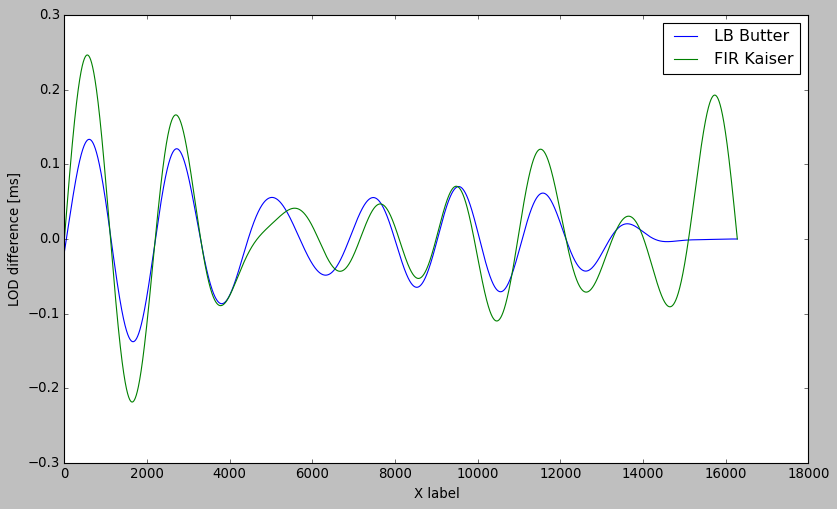

In [7]:
filtered_butter  = signal.sosfiltfilt(sos, sig)
filtered_FIR = signal.filtfilt(taps, 1.0, sig)
plt.figure()
plt.plot(x,filtered_butter, label = 'LB Butter')
plt.plot(x,filtered_FIR, label = 'FIR Kaiser')
plt.ylabel('LOD difference [ms]')
plt.xlabel('X label')
plt.legend(loc="upper right");

## Smoothing spline

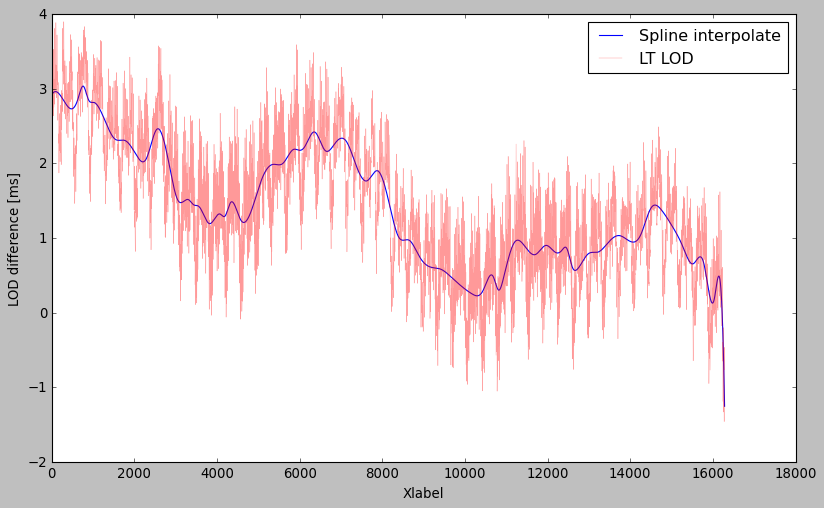

In [8]:
spl = interpolate.UnivariateSpline(x, sig,k=3)
spl.set_smoothing_factor(4000) #This factor will set the "degree of interpolation"

#Plot
plt.figure()
plt.plot(x,spl(x), label = 'Spline interpolate')
plt.plot(x,sig,c='r', label = 'LT LOD',lw = 0.4, alpha = 0.4)
plt.ylabel('LOD difference [ms]')
plt.xlabel('Xlabel')
plt.legend(loc="upper right");